In [1]:
import os
import sys
import numpy as np
# import psycopg2
import sqlalchemy
import pandas as pd
from collections import defaultdict

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(
    context='paper',
    font_scale=8/8.8,
#     context="talk",
    style='ticks',
    color_codes=True,
    rc={'legend.frameon': False})

plt.rcParams['svg.fonttype'] = 'none'

%matplotlib inline

In [2]:
import datashader as ds
from datashader.mpl_ext import dsshow
import datashader.transfer_functions as dstf

In [3]:
print(np.__version__)
print(pd.__version__)

1.21.5
1.3.5


In [4]:
os.chdir('../')

In [5]:
print(os.getcwd())
sys.path.append('../../')
import rlmolecule
from rlmolecule.sql.run_config import RunConfig
from rlmolecule.sql import Base, Session
from rlmolecule.sql.tables import GameStore, RewardStore, StateStore

/home/jlaw/projects/arpa-e/crystals/rlmolecule/examples/crystal_energy


In [6]:
# connect to the db
# config_file = "config/config_eagle.yaml"
config_file = "/projects/rlmolecule/jlaw/logs/crystal_energy/20220109-rel-energy-cos-dist0.1-eles3/run.yaml"
run_config = RunConfig(config_file)
engine = run_config.start_engine()
Session.configure(bind=engine)
session = Session()

In [7]:
def load_games_played(session, run_id):
#     print("Loading games")
    df = pd.read_sql(session.query(GameStore).filter_by(run_id=run_id).statement, session.bind)

    df['time_hours'] = (df.time - df.time.min()).apply(lambda x: x.total_seconds() / 3600)
    df = df.sort_values('time_hours')
    df_games = df
    df_games.reset_index(drop=True, inplace=True)
#     print(df_games.tail(3))
    return df_games


def load_rewards(session, run_id):
#     print("Loading rewards")
    df = pd.read_sql(session.query(RewardStore).filter_by(run_id=run_id).statement, session.bind)
    # df['time_hours'] = (df.time - df.time.min()).apply(lambda x: x.total_seconds() / 3600)
    df = df.sort_values('reward', ascending=False)
    df_rew = df
#     print(df_rew.tail(3))
    return df_rew


def load_states(session, run_id):
#     print("Loading rewards")
    df = pd.read_sql(session.query(StateStore).filter_by(run_id=run_id).statement, session.bind)
    return df

def get_state_for_rew(digest, df_state):
    return df_state[df_state['digest'] == digest]


# def write_best_crystals():
#     df_rew = load_rewards

In [8]:
def plot_reward(df, log, out_dir, title=""):
    fig, ax = plt.subplots(figsize=(3, 2.75), dpi=150)
    axs = [ax]
    axs[0].plot(df.time_hours, df.raw_reward, '.', ms=.75, label='games')
    axs[0].plot(df.time_hours, df.raw_reward.rolling(250, min_periods=50).quantile(.75), label='$r_{75}$')

    axs[0].legend(loc='upper right', ncol=2, borderpad=0, borderaxespad=0,
                bbox_to_anchor=(1.1, 1.2), markerscale=10)

    axs[0].set_yticks(np.arange(-5, 5, 2))
    axs[0].set_ylabel('Reward')

    plt.tight_layout()
    sns.despine(offset=5, trim=True)
    plt.title(title)

    out_file = f"{out_dir}/training.svg"
    print(out_file)
    os.makedirs(os.path.dirname(out_file), exist_ok=True)
    plt.savefig(out_file, bbox_inches="tight")
    plt.savefig(out_file.replace('.svg','.pdf'), bbox_inches="tight")
    plt.savefig(out_file.replace('.svg','.png'), bbox_inches="tight")
    plt.show()
    plt.close()

In [9]:
def plot_reward_train_curves(df, log, out_dir, title=""):
    fig, axs = plt.subplots(sharex=True, nrows=2, figsize=(3, 2.75), dpi=150)
    axs[0].plot(df.time_hours, df.raw_reward, '.', ms=.75, alpha=.5, label='games')
    axs[0].plot(df.time_hours, df.raw_reward.rolling(250, min_periods=50).quantile(.75), label='$r_{75}$')

    axs[1].plot(log.time_hours, log.policy_wrapper_loss, label='value loss')
    axs[1].plot(log.time_hours, log.policy_wrapper_1_loss, label='prior loss')

    axs[0].legend(loc='upper right', ncol=2, borderpad=0, borderaxespad=0,
                bbox_to_anchor=(1.1, 1.2), markerscale=10)
    axs[1].legend(
        loc='upper right', ncol=2,
        borderpad=0, borderaxespad=0.1,
        bbox_to_anchor=(1.1, 1.2))

    #axs[1].set_ylim([0, .7])
    #axs[1].set_xlim([-.01, 4])
    axs[0].set_yticks(np.arange(-6, 4, 2))
    axs[0].set_ylim(-6.1, 3.5)
    axs[1].set_yticks(np.arange(0, .7, .2))
    axs[1].set_ylim(0, .62)
    axs[0].set_ylabel('Reward')
    axs[1].set_ylabel('Policy Training')
    axs[1].set_xlabel('Time (hours)')

    plt.tight_layout()
    sns.despine(offset=5, trim=True)
    plt.suptitle(title, y=1.0)

    out_file = f"{out_dir}/training-and-reward.svg"
    print(out_file)
    os.makedirs(os.path.dirname(out_file), exist_ok=True)
#     plt.savefig(out_file, bbox_inches="tight")
#     plt.savefig(out_file.replace('.svg','.pdf'), bbox_inches="tight")
    plt.savefig(out_file.replace('.svg','.png'), bbox_inches="tight")
    plt.show()
    plt.close()

# Compare Experiment Results

In [169]:
def main_results(run_id, session):
    working_dir = f"/projects/rlmolecule/jlaw/logs/{exp_name}/{run_id}"
    # load the games played
    df_games = load_games_played(session, run_id)
#     print(df_games.head(2))
#     print(len(df_games))

    log_file = f"{working_dir}/policy_checkpoints/log.csv"
    print(f"Reading {log_file}")
    log = pd.read_csv(log_file)
    log['time'] = pd.to_datetime(log.time)
    log['time'] = pd.to_datetime(log.time)
    log['time_hours'] = (log.time - df_games.time.min()).apply(lambda x: x.total_seconds() / 3600)
    # make sure the times line up
    df_games2 = df_games[df_games.time > log.time.min()]
#     print(log.tail(3))

    # now plot the results
    out_dir = f"{working_dir}/viz"
#     plot_reward(df_games, log, out_dir, title=run_id)
#     plot_reward_train_curves(df_games, log, out_dir, title=run_id)
    plot_reward_train_curves(df_games2, log, out_dir)

    # and write POSCAR files for the best molecules
    df_rew = load_rewards(session, run_id)
#     print(df_rew.head(2))
    return df_games, df_rew

In [159]:
exp_name = "crystal_energy"
run_id = run_config.run_id
print(run_id)

20220109-rel-energy-cos-dist0.1-eles3


Reading /projects/rlmolecule/jlaw/logs/crystal_energy/20220109-rel-energy-cos-dist0.1-eles3/policy_checkpoints/log.csv
/projects/rlmolecule/jlaw/logs/crystal_energy/20220109-rel-energy-cos-dist0.1-eles3/viz/training-and-reward.svg


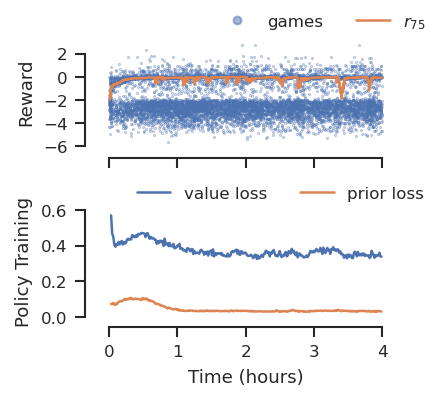

In [160]:
df_games, df_rew = main_results(run_id, session)

In [340]:
df_rew.head(2)

digest                 hash  \
39991  65758da4f6c396161609713f524938b942987ca8f96d5a...  2249590905664585109   
55074  09de7fab6ee0b466cd6620777c8e8ff61acb2895310b49...  2105195759225132896   

                                        run_id                       time  \
39991  20220109-rel-energy-cos-dist0.1-eles3-K 2022-01-18 11:23:35.127361   
55074  20220109-rel-energy-cos-dist0.1-eles3-K 2022-01-18 11:33:50.552704   

       reward                                               data  
39991   1.803  {'terminal': True, 'predicted_energy': -5.9024...  
55074   1.803  {'terminal': True, 'predicted_energy': -5.8089...

In [13]:
df_rew.iloc[0]['data']

{'terminal': True,
 'predicted_energy': -5.9797773361206055,
 'hull_energy': -2.755,
 'num_sites': 20,
 'dist_pred': 0.48341187834739685,
 'state_repr': 'Na1Sc2F7|_1_2_7|monoclinic|POSCAR_sg14_icsd_423437|1'}

Reading /projects/rlmolecule/jlaw/logs/crystal_energy/20220302-rel-dist0.1-eles3/policy_checkpoints/log.csv
/projects/rlmolecule/jlaw/logs/crystal_energy/20220302-rel-dist0.1-eles3/viz/training-and-reward.svg


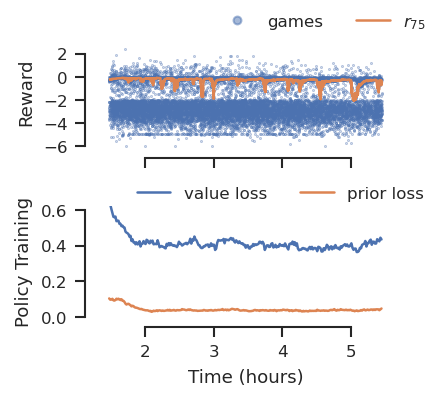

In [383]:
run_id = "20220302-rel-dist0.1-eles3"
# run_id = "20220109-rel-energy-cos-dist0.1-eles3"
# run_id = "20220109-rel-energy-cos-dist0.1-eles3-K"
df_games, df_rew = main_results(run_id, session)

In [384]:
df_rew['state'] = df_rew['data'].apply(lambda x: x['state_repr'])
df_rew.head(2)

digest  \
224957  eb57b04750a83a650e7b5f01da89727f3bfebfb04d7703...   
89701   9bc23b2e94952ffeda27b41c032395631f096db07c4848...   

                       hash                      run_id  \
224957  8506336403265687914  20220302-rel-dist0.1-eles3   
89701   9111406711824834954  20220302-rel-dist0.1-eles3   

                             time  reward  \
224957 2022-03-02 11:06:56.427930   2.755   
89701  2022-03-02 10:28:05.183556   2.745   

                                                     data  \
224957  {'terminal': True, 'predicted_energy': -5.9797...   
89701   {'terminal': True, 'predicted_energy': -5.9694...   

                                                    state  
224957  Na1Sc2F7|_1_2_7|monoclinic|POSCAR_sg14_icsd_42...  
89701   Na1Sc2F7|_1_2_7|triclinic|POSCAR_sg2_icsd_0748...

In [385]:
df_rew['state'].nunique()

695785

In [386]:
len(df_rew)

726048

In [387]:
len(set([s.split('|')[0] for s in df_rew[df_rew['reward'] > 1]['state']]))

46

In [388]:
df_rew[df_rew['reward'] > 1]['state'].nunique()

277

In [345]:
states_to_ignore = defaultdict(set)
states = set([data['state_repr'] for data in df_rew['data']])
for state in states:
    comp = state.split('|')[0]
    decoration_node = '|'.join(state.split('|')[1:])
    states_to_ignore[comp].add(decoration_node)

In [360]:
df_rew.sort_values('state').head(5)

digest  \
380903  c7adf128a59fa00cd48de494e8e654a4ec9a1795c3854d...   
211258  a097ba0f713d18a4dc7979855dc0c9f480bb8b58218c6d...   
211656  a097ba0f713d18a4dc7979855dc0c9f480bb8b58218c6d...   
211260  990b2011acea490a321d9dd5fee4da3ac87343d15ee7d1...   
210926  990b2011acea490a321d9dd5fee4da3ac87343d15ee7d1...   

                       hash                                 run_id  \
380903  1122049614249007920  20220109-rel-energy-cos-dist0.1-eles3   
211258  6799643574878796477  20220109-rel-energy-cos-dist0.1-eles3   
211656  9042318099721185863  20220109-rel-energy-cos-dist0.1-eles3   
211260  6821333847494147164  20220109-rel-energy-cos-dist0.1-eles3   
210926  4243385271632251239  20220109-rel-energy-cos-dist0.1-eles3   

                             time  reward  \
380903 2022-01-09 01:03:15.732638  -3.073   
211258 2022-01-09 03:11:39.980306  -2.511   
211656 2022-01-09 03:11:54.439277  -2.029   
211260 2022-01-09 03:11:42.039509  -2.721   
210926 2022-01-09 03:11:25.684835  -3.159   

                                                     data  \
380903  {'terminal': True, 'predicted_energy': -3.0858...   
211258  {'terminal': True, 'predicted_energy': -2.9471...   
211656  {'terminal': True, 'predicted_energy': -2.4006...   
211260  {'terminal': True, 'predicted_energy': -1.7087...   
210926  {'terminal': True, 'predicted_energy': -2.3003...   

                                                    state  
380903  K1Al1Br1P1|_1_1_1_1|trigonal|POSCAR_sg156_icsd...  
211258  K1Al1Br2S1|_1_1_1_2|hexagonal|POSCAR_sg178_ics...  
211656  K1Al1Br2S1|_1_1_1_2|hexagonal|POSCAR_sg178_ics...  
211260  K1Al1Br2S1|_1_1_1_2|hexagonal|POSCAR_sg188_ics...  
210926  K1Al1Br2S1|_1_1_1_2|hexagonal|POSCAR_sg188_ics...

In [354]:
sorted(list(states_to_ignore.keys()))[:10]

["('La', 'Mg', 'P', 'Sc')",
 'K1Al1Cl4',
 'K1Al1F4',
 'K1Al1I4',
 'K1Al1O2',
 'K1Al1Sb1Cl6P1',
 'K1Al1Sb2Cl2P4',
 'K1Al1Si1S4',
 'K1Al1Si2S6',
 'K1Al1Sn1O4']

### Write best structures from multiple MCTS runs

In [335]:
stats = {}
df_all = pd.DataFrame()
rew_cutoff = 1
for run_id in [
    "20220109-rel-energy-cos-dist0.1-eles3",
    "20220109-rel-energy-cos-dist0.1-eles3-Li",
    "20220109-rel-energy-cos-dist0.1-eles3-Na",
    "20220109-rel-energy-cos-dist0.1-eles3-Mg",
    "20220109-rel-energy-cos-dist0.1-eles3-Zn",
    "20220109-rel-energy-cos-dist0.1-eles3-K",
    # "20220119-rel-dist0.1-eles3-halides",
    # "20220119-rel-dist0.1-eles3-oxides",
    # "20220119-rel-dist0.1-eles3-sulfo-halides",
    # "20220125-skynet-rel-dist0.1-eles3-Mg-halides",
    # "20220125-skynet-rel-dist0.1-eles3-Mg-oxides",
    # # "20220125-skynet-rel-dist0.1-eles3-Mg-sulfides",
    # "20220125-skynet-rel-dist0.1-eles3-Mg-sulfo-halides",
    ]:
    df_rew = load_rewards(session, run_id)
    # df_games, df_rew = main_results(run_id, session)
    top_rew = df_rew[df_rew['reward'] > rew_cutoff]
    best_crystal_states = {}
    for rew, data in top_rew[['reward', 'data']].values:
        best_crystal_states[data['state_repr']] = (
            rew, data['hull_energy'], 
            data['predicted_energy'], data['dist_pred'])
    best_crys_comp = [s.split('|')[0] for s in best_crystal_states]
    S = pd.Series(list(best_crys_comp))
    comp_counts = S.value_counts()

    # print(len(top_rew))
    # print(len(best_crystal_states))
    print(df_rew[df_rew['reward'] > rew_cutoff]['data'].apply(lambda x: x['state_repr']).nunique())
    print(f"# compositions: {len(comp_counts)}")
    stats[run_id] = (len(best_crystal_states), len(comp_counts))
    
    # now write each of these to a file
    out_dir = f"outputs/{run_id}/best_decorations"
    print(f"writing decorations to {out_dir}")
    os.makedirs(out_dir, exist_ok=True)
    out_strs = {}
    for decorated_str, data in tqdm(best_crystal_states.items()):
        out_str = write_decorated_structure(decorated_str, out_dir, structures)
        out_strs[out_str] = data
    df_out = pd.DataFrame(out_strs).T
    df_out.to_csv(f"outputs/{run_id}/best_decorations.csv", index_label='id',
                  header=['reward', 'pred_decomp_energy', 'pred_energyperatom', 'dist_pred'])
    df_all = pd.concat([df_all, df_out])

122
# compositions: 30
writing decorations to outputs/20220109-rel-energy-cos-dist0.1-eles3/best_decorations


  0%|          | 0/122 [00:00<?, ?it/s]

111
# compositions: 23
writing decorations to outputs/20220109-rel-energy-cos-dist0.1-eles3-Li/best_decorations


  0%|          | 0/111 [00:00<?, ?it/s]

54
# compositions: 11
writing decorations to outputs/20220109-rel-energy-cos-dist0.1-eles3-Na/best_decorations


  0%|          | 0/54 [00:00<?, ?it/s]

28
# compositions: 7
writing decorations to outputs/20220109-rel-energy-cos-dist0.1-eles3-Mg/best_decorations


  0%|          | 0/28 [00:00<?, ?it/s]

31
# compositions: 7
writing decorations to outputs/20220109-rel-energy-cos-dist0.1-eles3-Zn/best_decorations


  0%|          | 0/31 [00:00<?, ?it/s]

79
# compositions: 11
writing decorations to outputs/20220109-rel-energy-cos-dist0.1-eles3-K/best_decorations


  0%|          | 0/79 [00:00<?, ?it/s]

In [339]:
out_file = "/projects/rlmolecule/jlaw/crystals/2022-01-18/best_decorations.csv"
df_all.drop_duplicates().to_csv(out_file, index_label='id',
                  header=['reward', 'pred_decomp_energy', 'pred_energyperatom', 'dist_pred'])

In [338]:
len(df_all.drop_duplicates())

303

In [250]:
print('run_id\t# decorations\t# compositions')
for run_id, (num_s, num_c) in stats.items():
    print('\t'.join(map(str, [run_id, num_s, num_c])))

run_id	# decorations	# compositions
20220125-skynet-rel-dist0.1-eles3-Mg-halides	21	4
20220125-skynet-rel-dist0.1-eles3-Mg-oxides	7	7
20220125-skynet-rel-dist0.1-eles3-Mg-sulfides	0	0
20220125-skynet-rel-dist0.1-eles3-Mg-sulfo-halides	22	4


### write all reward values for sulfides, since no structures reached the cutoff

Reading /projects/rlmolecule/jlaw/logs/crystal_energy/20220120-skynet-rel-dist0.1-eles3-sulfides/policy_checkpoints/log.csv
/projects/rlmolecule/jlaw/logs/crystal_energy/20220120-skynet-rel-dist0.1-eles3-sulfides/viz/training-and-reward.svg


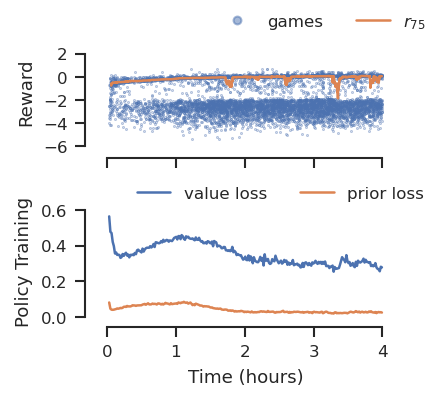

In [327]:
# run_id = "20220119-rel-dist0.1-eles3-sulfides"
run_id = "20220120-skynet-rel-dist0.1-eles3-sulfides"
# run_id = "20220125-skynet-rel-dist0.1-eles3-Mg-sulfides"
df_games, df_rew = main_results(run_id, session)

In [328]:
df_energy = pd.DataFrame({
    data['state_repr']: (rew, data['hull_energy'], data['predicted_energy'], data['dist_pred']) \
    for rew, data in df_rew[['reward', 'data']].values if 'hull_energy' in data}).T
df_energy.columns = ['reward', 'hull_energy', 'predicted_energy', 'dist_pred']
# decomp_energy = pd.Series({row['state_repr']: row['hull_energy'] for row in df_rew['data'].values if 'hull_energy' in row})
# dist_pred = pd.Series({row['state_repr']: row['dist_pred'] for row in df_rew['data'].values if 'dist_pred' in row})
# f, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8,4))
# decomp_energy.hist(bins=30, ax=ax1)
# ax1.set_xlabel('decomp_energy_pred')
# dist_pred.hist(bins=30, ax=ax2)
# ax2.set_xlabel('dist_pred')
# plt.suptitle(run_id)

In [329]:
sulfides = decomp_energy[decomp_energy < -1]
print(len(sulfides))
sulfide_comps = set([x.split('|')[0] for x in decomp_energy[decomp_energy < -1].index])
print(len(sulfide_comps))

50
25


In [330]:
# now write the best structures to a file
top_rew = df_energy[df_energy['hull_energy'] < -1]
out_dir = f"outputs/{run_id}/best_decorations"
print(f"writing decorations to {out_dir}")
os.makedirs(out_dir, exist_ok=True)
out_strs = {}
for decorated_str in tqdm(top_rew.index):
    out_str = write_decorated_structure(decorated_str, out_dir, structures)
    out_strs[decorated_str] = out_str
# top_rew['out_str'] = pd.Series(out_strs)
top_rew.rename(index=out_strs, inplace=True)
top_rew.to_csv(f"outputs/{run_id}/best_decorations.csv", index_label='id',
              header=['reward', 'pred_decomp_energy', 'pred_energyperatom', 'dist_pred'])

writing decorations to outputs/20220120-skynet-rel-dist0.1-eles3-sulfides/best_decorations


  0%|          | 0/35 [00:00<?, ?it/s]

/lustre/eaglefs/projects/rlmolecule/jlaw/envs/crystals_nfp0_3/lib/python3.8/site-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


### Analyze the best structures

In [155]:
print(df_rew[df_rew['reward'] > 1][['hash', 'digest']].nunique())

hash       79
digest    249
dtype: int64


In [161]:
# get the unique states
print(df_rew[df_rew['reward'] > 0]['data'].apply(lambda x: x['state_repr']).nunique())
print(df_rew[df_rew['reward'] > 1]['data'].apply(lambda x: x['state_repr']).nunique())
print(df_rew[df_rew['reward'] > 2]['data'].apply(lambda x: x['state_repr']).nunique())

2293
122
9


In [141]:
top_states = df_rew[df_rew['reward'] > 0]['data'].apply(lambda x: x['state_repr']).unique()
# get the top states with 3 or more elements
len([s for s in top_states if len(s.split('|')[1]) > 4])

703

In [142]:
top_rew = df_rew[df_rew['reward'] > 0]
print(len(top_rew))

3953


In [143]:
# see how much repetition there is
crystal_states = []
for data in df_rew['data']:
    crystal_states.append(data['state_repr'])
print(len(crystal_states))
crystal_states = set(crystal_states)
print(len(crystal_states))

460058
247344


In [144]:
# get reward for each decoration
crystal_state_rew = {}
for rew, data in df_rew[['reward', 'data']].values:
    crystal_state_rew[data['state_repr']] = rew
print(len(crystal_state_rew))

247344


In [145]:
print(list(crystal_state_rew.items())[:2])

[('Zn1Sc1F5|_1_1_5|orthorhombic|POSCAR_sg71_icsd_078012|1', 2.465), ('Zn1Sc1F5|_1_1_5|orthorhombic|POSCAR_sg63_icsd_073812|2', 2.435)]


In [146]:
crys_comp = [s.split('|')[0] for s in crystal_states]
S = pd.Series(list(crys_comp))
comp_counts = S.value_counts()
# print(list(comp_counts.index))
comp_counts

Zn1F1Br1         425
Zn1Br1I1         375
Zn1Cl1I1         364
Zn1Cl1Br1        363
Zn1F1Cl1         346
                ... 
Zn1Ti1Zr1I4P2      1
Zn1Sc2Sb1I1N4      1
Zn1La1F2I3         1
Zn1Hf1B2S3N2       1
Zn3Ti2O1N4         1
Length: 7080, dtype: int64

In [147]:
# see what the best crystals are
best_crystal_states = {}
for rew, data in top_rew[['reward', 'data']].values:
    best_crystal_states[data['state_repr']] = rew
print(len(best_crystal_states))

703


In [148]:
S = pd.Series(best_crystal_states)
S

Zn1Sc1F5|_1_1_5|orthorhombic|POSCAR_sg71_icsd_078012|1              2.465
Zn1Sc1F5|_1_1_5|orthorhombic|POSCAR_sg63_icsd_073812|2              2.435
Zn1Sc1F5|_1_1_5|orthorhombic|POSCAR_sg62_icsd_261430|2              2.375
Zn1Sc1F5|_1_1_5|orthorhombic|POSCAR_sg71_icsd_078012|2              2.283
Zn1Sc1F5|_1_1_5|orthorhombic|POSCAR_sg63_icsd_073812|1              2.209
                                                                    ...  
Zn1Ti1Sb2Cl1P5|_1_1_1_2_5|orthorhombic|POSCAR_sg29_icsd_086096|6    0.001
Zn2Sn1Sb1O5P1|_1_1_1_2_5|tetragonal|POSCAR_sg104_icsd_086200|6      0.001
Zn2Si1Cl6S1|_1_1_2_6|orthorhombic|POSCAR_sg62_icsd_035428|2         0.001
Zn1Hg1Al1Cl6I1|_1_1_1_1_6|cubic|POSCAR_sg216_icsd_039604|16         0.001
Zn2Br2S1|_1_2_2|monoclinic|POSCAR_sg12_icsd_174134|1                0.001
Length: 703, dtype: float64

In [149]:
best_crys_comp = [s.split('|')[0] for s in best_crystal_states]
S = pd.Series(list(best_crys_comp))
comp_counts = S.value_counts()
print(list(comp_counts.index))

['Zn1Ge1P2', 'Zn1Sc1F5', 'Zn1Si1P2', 'Zn1Sn1P2', 'Zn1Y1O1P1', 'Zn2Br1N1', 'Zn2I1N1', 'Zn1Sc1Br5', 'Zn1Ge1N2', 'Zn2Cl1N1', 'Zn1Sc1I5', 'Zn2Sc1F7', 'Zn1Si1N2', 'Zn2P1N3', 'Zn1Hf1Br6', 'Zn1Sc1Cd1Br7', 'Zn1Sc1Cd1I7', 'Zn1Sc1Cd1Br6I1', 'Zn1Sc1Hg1I7', 'Zn1P2O6', 'Zn1Sc1Hg1Br7', 'Zn1Y1Br5', 'Zn1Sb2O6', 'Zn1Y1Cd1Br6I1', 'Zn1Al2S4', 'Zn1Al1Br5', 'Zn2Y1Br7', 'Zn1Y1Hg1Br7', 'Zn1Al2O4', 'Zn2Sc1Br6I1', 'Zn1Y1Cd1Br7', 'Zn1Hf1Br5I1', 'Zn2Sc1Br7', 'Zn2Sc1I7', 'Zn1Sc1F4I1', 'Zn1Hg1Al1Br7', 'Zn1Sc1Br4I1', 'Zn2Ge1O4', 'Zn1Zr2W1O2N4', 'Zn2Al1Br7', 'Zn1Y2Br5P1', 'Zn1Cd1F2O1', 'Zn1Ge1F6', 'Zn1Zr1Br6', 'Zn1Hf1Cl1Br5', 'Zn2Zr1Hf1N4', 'Zn1Hf1N2', 'Zn2Hf1Sn1N4', 'Zn1W1Ge2O2N4', 'Zn1Y1Cl1Br4', 'Zn1Sc1Cl1I4', 'Zn2W1Ge1Cl2N4', 'Zn1Sc1F1I4', 'Zn1Cd1Al1Br7', 'Zn1Sn1F6', 'Zn1W2Cd1O2N4', 'Zn1Ti1F6', 'Zn1Y2Br6S1', 'Zn1Sc1F2N1', 'Zn2W1Cd1O4S2', 'Zn2Sc1B1Cl2O4', 'Zn1Sc1Br3I2', 'Zn1Hg1Sb2O4P2', 'Zn1Y1Br4I1', 'Zn1Y1F2N1', 'Zn1La1F2N1', 'Zn1Zr1Ge2Cl2N4', 'Zn2Sc1Al1Cl2O4', 'Zn1Al1F2P1', 'Zn1Hf1W1O6', 'Zn1B1F5', 'Zn1Y1Cd1Cl1B

In [150]:
len(comp_counts)

109

In [26]:
decorations = pd.read_csv("/projects/rlmolecule/jlaw/crystals/2021-09-22/all-decorations-c150.txt.gz", 
                          header=None,
                          squeeze=True)
print(len(decorations))
decorations.head(3)

14978150


0     K3P1|_1_3|monoclinic|POSCAR_sg9_icsd_261955|1
1    K3P1|_1_3|monoclinic|POSCAR_sg15_icsd_010490|1
2    K3P1|_1_3|monoclinic|POSCAR_sg15_icsd_039430|1
Name: 0, dtype: object

In [27]:
crys_comp = [s.split('|')[0] for s in decorations]
S = pd.Series(list(crys_comp))
S.value_counts()

Mg1Y1O1N1      984
Na1La1Br1P1    984
Li1Sc1O1S1     984
Na1Hg1Cl1O1    984
Mg1B1S1P1      984
              ... 
K3Sn2F2N3        4
Na2Sb2Br3P3      4
Mg2Hf2Br3P3      4
K3Zn2Br3O2       4
Na3Sn2I2P3       4
Length: 138776, dtype: int64

write a file with: 
- the comp
- num decorations
- num decorations with reward value
- num decorations > cutoff
- fraction that are stable (hull energy < 0) (?)
- avg hull energy

In [117]:
def get_comp_counts(state_rew):
    crys_comp = [s.split('|')[0] for s in state_rew]
    S = pd.Series(list(crys_comp))
    comp_counts = S.value_counts()
    # print(list(comp_counts.index))
    return comp_counts


def get_state_rew(df_rew):
    # get reward for each decoration
    state_rew = {}
    for rew, data in df_rew[['reward', 'data']].values:
        state_rew[data['state_repr']] = rew
    return state_rew
# print(f"{len(state_rew)} / {len(decorations)} states with a reward value")

comp_counts = get_comp_counts(decorations)
df = pd.DataFrame({'comp_counts': comp_counts})
state_rew = get_state_rew(df_rew)
comp_counts = get_comp_counts(state_rew)
df['comp_counts_rew'] = comp_counts

for cutoff in range(3):
    state_rew_cutoff = get_state_rew(df_rew[df_rew['reward'] > cutoff])
    comp_counts_cutoff = get_comp_counts(state_rew_cutoff)
    print(f"{len(comp_counts_cutoff)} compositions with reward > {cutoff}")
    df[f'comp_counts_{cutoff}'] = comp_counts_cutoff
df.head(3)

106 compositions with reward > 0
7 compositions with reward > 1
1 compositions with reward > 2


comp_counts  comp_counts_rew  comp_counts_0  comp_counts_1  \
Mg1Y1O1N1            984            107.0            NaN            NaN   
Na1La1Br1P1          984              NaN            NaN            NaN   
Li1Sc1O1S1           984              NaN            NaN            NaN   

             comp_counts_2  
Mg1Y1O1N1              NaN  
Na1La1Br1P1            NaN  
Li1Sc1O1S1             NaN

In [118]:
def get_avg_rew(state_rew):
    comp_rew = defaultdict(list)
    for s, rew in state_rew.items():
        comp = s.split('|')[0]
        comp_rew[comp].append(rew)
    return comp_rew

comp_rew = get_avg_rew(state_rew)
avg_rew = {c: np.mean(rew) for c, rew in comp_rew.items()}
S = pd.Series(avg_rew)
df['avg_rew'] = S
df.head(2)

comp_counts  comp_counts_rew  comp_counts_0  comp_counts_1  \
Mg1Y1O1N1            984            107.0            NaN            NaN   
Na1La1Br1P1          984              NaN            NaN            NaN   

             comp_counts_2   avg_rew  
Mg1Y1O1N1              NaN -4.351009  
Na1La1Br1P1            NaN       NaN

In [119]:
out_dir = f"outputs/{run_id}"
os.makedirs(out_dir, exist_ok=True)

In [120]:
out_file = f"{out_dir}/comp_stats.csv"
print(out_file)
df.to_csv(out_file)

outputs/20220109-rel-energy-cos-dist0.1-eles3-Mg/comp_stats.csv


### Save the crystals structures of the best states

In [121]:
# for each composition, find the
# build a mapping from composition to decoration string
comp_to_decors = defaultdict(set)
for s, rew in crystal_state_rew.items():
    comp = s.split('|')[0]
    comp_to_decors[comp].add((s, rew))
list(comp_to_decors.items())[-2]

('Mg4Sn1N2P2',
 {('Mg4Sn1N2P2|_1_2_2_4|monoclinic|POSCAR_sg12_icsd_170865|2', -12.0)})

In [99]:
# from examples.crystal_volume import optimize_crystal_volume as ocv
from rlmolecule.crystal.crystal_state import CrystalState
from tqdm.auto import tqdm

In [100]:
import gzip, json
from pymatgen.core import Structure
def read_structures_file(structures_file):
    print(f"reading {structures_file}")
    with gzip.open(structures_file, 'r') as f:
        structures_dict = json.loads(f.read().decode())
    structures = {}
    for key, structure_dict in structures_dict.items():
        structures[key] = Structure.from_dict(structure_dict)
    print(f"\t{len(structures)} structures read")
    return structures

In [36]:
# load the icsd prototype structures
# https://pymatgen.org/usage.html#side-note-as-dict-from-dict
icsd_prototypes_file = "../../rlmolecule/crystal/inputs/icsd_prototypes.json.gz"
structures = read_structures_file(icsd_prototypes_file)

reading ../../rlmolecule/crystal/inputs/icsd_prototypes.json.gz
	4170 structures read


In [47]:
def write_decorated_structure(decorated_str, out_dir, icsd_structures):
    # Now create the decoration of this composition onto this prototype structure
    # the 'action_node' string has the following format at this point:
    # comp_type|prototype_structure|decoration_idx
    # we just need 'comp_type|prototype_structure' to get the icsd structure
    composition = decorated_str.split('|')[0]
    structure_key = '|'.join(decorated_str.split('|')[1:-1])
    icsd_prototype = icsd_structures[structure_key]
    decoration_idx = int(decorated_str.split('|')[-1]) - 1
    # print(decorated_str, composition, structure_key)
    try:
        decorated_structure, comp = CrystalState.decorate_prototype_structure(
            icsd_prototype, composition, decoration_idx=decoration_idx)
        #decorations[descriptor] = decorated_structure.as_dict()
    except AssertionError as e:
        print(f"AssertionError: {e}")
        return
        #volume_stats[descriptor] = (-1, -1, 0, comp_type)
        #return 0.0, {'terminal': True, 'state_repr': repr(state)}

    decor_split = decorated_str.split('|')
    out_str = '_'.join([decor_split[0], decor_split[3].replace('POSCAR_',''), decor_split[4]])
    out_file = f"{out_dir}/POSCAR_{out_str}"
    # print(f"writing {out_file}")
    decorated_structure.to(filename=out_file)
    
    # also write the original poscar file for reference
    out_file2 = f"{out_dir}/icsd_structures/{decorated_str.split('|')[-2]}"
    os.makedirs(os.path.dirname(out_file2), exist_ok=True)
    if not os.path.isfile(out_file2):
        icsd_prototype.to(filename=out_file2)
        
    return out_str

In [136]:
run_id

'20220109-rel-energy-cos-dist0.1-eles3-Na'

In [39]:
top_rew.head(2)

digest  \
376137  7652c163820dff55ed3dc6625c53d9835137a07f710aaf...   
123629  315ce6d8ba87cad0f4e0a40f29594c7a7000b626e4c639...   

                       hash                                 run_id  \
376137  8506336403265687914  20220109-rel-energy-cos-dist0.1-eles3   
123629  8506336403265687914  20220109-rel-energy-cos-dist0.1-eles3   

                             time  reward  \
376137 2022-01-09 04:42:01.760457   2.755   
123629 2022-01-09 02:01:41.184979   2.755   

                                                     data  
376137  {'terminal': True, 'predicted_energy': -5.9797...  
123629  {'terminal': True, 'predicted_energy': -5.9797...

In [137]:
# now write each of these to a file
out_dir = f"outputs/{run_id}/best_decorations"
os.makedirs(out_dir, exist_ok=True)
out_strs = {}
for decorated_str, rew in tqdm(best_crystal_states.items()):
    out_str = write_decorated_structure(decorated_str, out_dir, structures)
    out_strs[out_str] = rew

  0%|          | 0/1205 [00:00<?, ?it/s]

<AxesSubplot:>

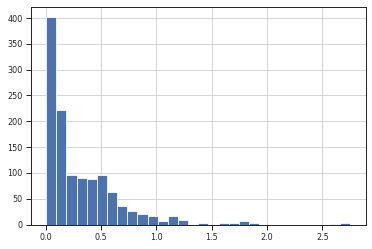

In [138]:
S_out = pd.Series(out_strs)
S_out.to_csv(f"outputs/{run_id}/best_decorations.csv")
S_out.hist(bins=30)

In [132]:
df.head(2)

predicted_energy  hull_energy
Mg1F2|_1_2|monoclinic|POSCAR_sg11_icsd_164631|1         -4.990279        3.961
Mg1F2|_1_2|cubic|POSCAR_sg224_icsd_170483|1             -4.989765        3.961

In [142]:
# write the predicted decomposition energy and energyperatom to file
def format_key(action_str):
    a = action_str.split('|')
    return '_'.join([a[0], a[3].replace('POSCAR_',''), a[4]])

df_out = df[df.index.isin([s for s, e in comp_low_decomp_energy.values()])]
df_out.rename({
    'hull_energy': 'pred_decomp_energy', 
    'predicted_energy': 'pred_energyperatom'}, 
    axis=1, inplace=True)
df_out.rename({key: format_key(key) for key in df_out.index}, axis=0, inplace=True)
df_out.to_csv(f"{out_dir}/pred_energies.csv")
df_out.head(2)

/home/jlaw/.conda/envs/crystals/lib/python3.8/site-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


pred_energyperatom  pred_decomp_energy
Zn1Sc1F5_sg194_icsd_646285_1           -5.982055               3.025
Zn6N1P3_sg14_icsd_027070_1             -6.363924               3.009

In [95]:


S = pd.Series({format_key(a): b for a,b in comp_low_decomp_energy.values()})
S.head(2)

Zn6N1P3_sg14_icsd_027070_1      3.009
Zn1Sc1F5_sg194_icsd_646285_1    3.025
dtype: float64

In [104]:
S2 = pd.Series({format_key(key): val for key,val in crystal_state_rew.items()})
df_out = pd.DataFrame({'pred_decomp_energy': S, 'pred_energyperatom': S2})
df_out.dropna(inplace=True)
df_out.head(2)

pred_decomp_energy  pred_energyperatom
K1La1Zn4N4_sg144_icsd_280279_2               2.235               2.235
K1La1Zn4P4_sg11_icsd_245791_4                2.391               2.391

In [98]:
S.to_csv(f"{out_dir}/pred_energies.csv", header=None)

### Check if the Hull energy value is related to the predicted energy

In [35]:
data

{'terminal': True,
 'predicted_energy': -5.566433906555176,
 'hull_energy': -2.001,
 'num_sites': 20,
 'state_repr': 'Zn4B1Br2P3|_1_2_3_4|hexagonal|POSCAR_sg186_icsd_420783|1'}

In [36]:
state_pred = {}
for rew, data in df_rew[['reward', 'data']].values:
    if 'predicted_energy' in data:
        state_pred[data['state_repr']] = data['predicted_energy']
print(len(state_pred))

440081


In [38]:
df = pd.DataFrame({'predicted_energy': state_pred, 'hull_energy': crystal_state_rew})
df.head()

predicted_energy  \
Mg1F2|_1_2|orthorhombic|POSCAR_sg54_icsd_170551|1         -4.975453   
Mg1F2|_1_2|tetragonal|POSCAR_sg92_icsd_620210|1           -5.190797   
Mg1F2|_1_2|hexagonal|POSCAR_sg191_icsd_169578|1           -3.894496   
Mg1F2|_1_2|cubic|POSCAR_sg229_icsd_170475|1               -5.133155   
Mg1F2|_1_2|hexagonal|POSCAR_sg191_icsd_089700|1           -5.061181   

                                                   hull_energy  
Mg1F2|_1_2|orthorhombic|POSCAR_sg54_icsd_170551|1        3.961  
Mg1F2|_1_2|tetragonal|POSCAR_sg92_icsd_620210|1          3.961  
Mg1F2|_1_2|hexagonal|POSCAR_sg191_icsd_169578|1          3.961  
Mg1F2|_1_2|cubic|POSCAR_sg229_icsd_170475|1              3.961  
Mg1F2|_1_2|hexagonal|POSCAR_sg191_icsd_089700|1          3.961

In [39]:
len(df)

457841

In [149]:
!pip install pandas-bokeh

In [150]:
import pandas_bokeh
pandas_bokeh.output_notebook()

Loading BokehJS ...

In [40]:
out_dir

'outputs/hull_energy_batt_origlatt'

In [47]:
df['composition'] = df.index.map(lambda x: x.split('|')[0])
df.head(2)

predicted_energy  \
Mg1F2|_1_2|orthorhombic|POSCAR_sg54_icsd_170551|1         -4.975453   
Mg1F2|_1_2|tetragonal|POSCAR_sg92_icsd_620210|1           -5.190797   

                                                   hull_energy composition  
Mg1F2|_1_2|orthorhombic|POSCAR_sg54_icsd_170551|1        3.961       Mg1F2  
Mg1F2|_1_2|tetragonal|POSCAR_sg92_icsd_620210|1          3.961       Mg1F2

In [49]:
df_3ele = df[df['composition'].apply(lambda x: len(x) > 5)]
print(len(df_3ele))
df_3ele.head(2)

447671


predicted_energy  \
Zn1Sc1F5|_1_1_5|hexagonal|POSCAR_sg194_icsd_646...         -5.982055   
Zn6N1P3|_1_3_6|monoclinic|POSCAR_sg14_icsd_0270...         -6.363924   

                                                    hull_energy composition  
Zn1Sc1F5|_1_1_5|hexagonal|POSCAR_sg194_icsd_646...        3.025    Zn1Sc1F5  
Zn6N1P3|_1_3_6|monoclinic|POSCAR_sg14_icsd_0270...        3.009     Zn6N1P3

In [67]:
df_3ele['hull_energy'] = -df_3ele['hull_energy']
dft_eval_points = df_3ele[df_3ele['hull_energy'] < -2].groupby('composition').min()
df_3ele['hull_energy'] = -df_3ele['hull_energy']
dft_eval_points['hull_energy'] = - dft_eval_points['hull_energy']
dft_eval_points.head(2)

/tmp/ipykernel_27862/1546988706.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_3ele['hull_energy'] = -df_3ele['hull_energy']
/tmp/ipykernel_27862/1546988706.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_3ele['hull_energy'] = -df_3ele['hull_energy']


predicted_energy  hull_energy
composition                               
K1La1Zn4N4          -6.756291        2.235
K1La1Zn4P4          -6.137475        2.391

In [77]:
sns.set_context("notebook")

outputs/hull_energy_batt_origlatt/predicted-energy-by-hull-energy.svg


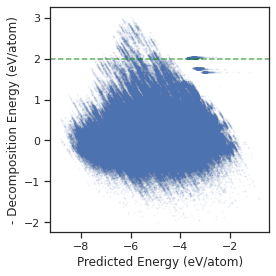

In [81]:
f, ax1 = plt.subplots(figsize=(4,4))

df_3ele[df_3ele['hull_energy'] > -2].plot.scatter(
    x='predicted_energy', y='hull_energy', ax=ax1,
    s=1, alpha=0.05)
# dft_eval_points.plot.scatter(
#     x='predicted_energy', y='hull_energy', ax=ax1,
#     s=5, alpha=0.4, c='green')

# ax1.set_title("All reward values")
ax1.set_ylabel("- Decomposition Energy (eV/atom)", fontsize=12)
ax1.set_xlabel("Predicted Energy (eV/atom)", fontsize=12)

ax1.axhline(y=2, color='green', alpha=.6, linestyle='--')

plt.tight_layout()
out_file = f"{out_dir}/predicted-energy-by-hull-energy.svg"
print(out_file)
# plt.savefig(out_file)
plt.savefig(out_file.replace('.svg','.png'), dpi=300, bbox_inches='tight')
# plt.savefig(out_file.replace('.svg','.pdf'))
plt.show()
plt.close()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


outputs/hull_energy_batt_origlatt/best_decor_per_comp_rew2/predicted-energy-by-hull-energy.svg


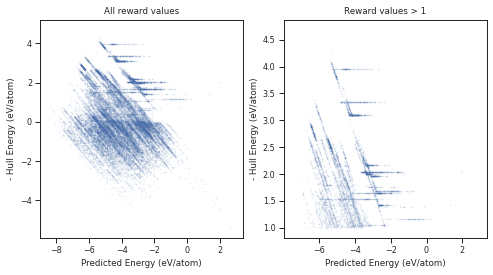

In [220]:
f, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8,4))

df.plot.scatter(
    x='predicted_energy', y='hull_energy', ax=ax1,
    s=1, alpha=0.05)
df[df['hull_energy'] > 1].plot.scatter(
    x='predicted_energy', y='hull_energy', ax=ax2,
    s=1, alpha=0.05)

# try adding labels:
# df2 = df.reset_index()
# df2[['predicted_energy','hull_energy','index']].apply(lambda x: ax2.text(*x),axis=1)

ax1.set_title("All reward values")
ax2.set_title("Reward values > 1")
for ax in (ax1, ax2):
    ax.set_ylabel("- Hull Energy (eV/atom)")
    ax.set_xlabel("Predicted Energy (eV/atom)")

out_file = f"{out_dir}/predicted-energy-by-hull-energy.svg"
print(out_file)
# plt.savefig(out_file)
plt.savefig(out_file.replace('.svg','.png'))
# plt.savefig(out_file.replace('.svg','.pdf'))
plt.show()
plt.close()

In [223]:
df.to_csv(out_file.replace('.svg','.csv'))

In [155]:
df[df['hull_energy'] > 1].plot_bokeh.scatter(
    x='predicted_energy', y='hull_energy',
    s=1, alpha=0.05)

Figure(id='1039', ...)

In [221]:
from bokeh.io import show
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.plotting import figure

In [ ]:
source = ColumnDataSource(data=df[df['hull_energy'] > 1])
p = figure(tools=[HoverTool(tooltips=[('Pred', '@predicted_energy'),
                                     ('Hull', '@hull_energy'),
                                     ('State', '@index')])])
p.scatter(x='predicted_energy', y='hull_energy', size=1, source=source)
show(p)

In [160]:
source = ColumnDataSource(data=df[df['hull_energy'] > 1])
p = figure(tools=[HoverTool(tooltips=[('Pred', '@predicted_energy'),
                                     ('Hull', '@hull_energy'),
                                     ('State', '@index')])])
p.scatter(x='predicted_energy', y='hull_energy', size=1, source=source)
show(p)

### Backup code for getting states

In [31]:
df_state = load_states(session, run_id)

In [32]:
df_state.head(2)

digest                 hash  \
0  00000b2146003a61d1986c3449893c245a25978937e171...  8851719026745735383   
1  00000edef4b5bf18e4c538f5fbc879550904f0ec926f60...  2197971990852685565   

                      run_id                       time  \
0  hull_energy_batt_origlatt 2021-09-25 01:49:43.449158   
1  hull_energy_batt_origlatt 2021-09-25 02:11:18.837103   

                                               state  \
0  b'x\x9ck`\x99:\x8b\x01\x02z\x14\x8arr\xf3sR\x9...   
1  b'x\x9ck`\x99\xba\x98\x01\x02z\x14\x8arr\xf3sR...   

                                       policy_inputs  
0  b'PK\x03\x04\x14\x00\x00\x00\x08\x00\x00\x00!\...  
1  b"PK\x03\x04\x14\x00\x00\x00\x08\x00\x00\x00!\...

In [34]:
len(df_state)

898172

In [38]:
import pickle
import zlib
from tqdm.notebook import tqdm

In [ ]:
best_states = []
for digest, hash_str, run_id, time, rew, data in tqdm(top_rew.values):
#     if digest in df_state['digest']:
    states = get_state_for_rew(digest, df_state)
    for state_str in states['state']:
#         state_str = get_state_for_rew(digest, df_state)['state'].values[0]
# #     if hash_str in df_state['hash']:
# #         state_str = df_state[df_state['hash'] == hash_str]['state'].values[0]
        crystal = pickle.loads(zlib.decompress(state_str))
        best_states.append(crystal)
len(best_states)

In [47]:
best_decorations = set([str(c) + '|1' if '|1' not in str(c) else str(c) for c in best_states])
len(best_decorations)

0

In [30]:
from examples.crystal_volume import optimize_crystal_volume as ocv
from rlmolecule.crystal.crystal_state import CrystalState
from tqdm.notebook import tqdm

INFO:examples.crystal_volume.optimize_crystal_volume:reading ../../rlmolecule/crystal/inputs/icsd_prototypes.json.gz
INFO:examples.crystal_volume.optimize_crystal_volume:	4170 structures read


In [31]:
def write_decorated_structure(decorated_str, out_dir):
    # Now create the decoration of this composition onto this prototype structure
    # the 'action_node' string has the following format at this point:
    # comp_type|prototype_structure|decoration_idx
    # we just need 'comp_type|prototype_structure' to get the icsd structure
    composition = decorated_str.split('|')[0]
    structure_key = '|'.join(decorated_str.split('|')[1:-1])
    icsd_prototype = ocv.structures[structure_key]
    decoration_idx = int(decorated_str.split('|')[-1]) - 1
    print(decorated_str, composition, structure_key)
    try:
        decorated_structure, comp = CrystalState.decorate_prototype_structure(
            icsd_prototype, composition, decoration_idx=decoration_idx)
        #decorations[descriptor] = decorated_structure.as_dict()
    except AssertionError as e:
        print(f"AssertionError: {e}")
        return
        #volume_stats[descriptor] = (-1, -1, 0, comp_type)
        #return 0.0, {'terminal': True, 'state_repr': repr(state)}

    # Compute the volume of the conducting ions.
    conducting_ion_vol, total_vol = ocv.compute_structure_vol(decorated_structure)
    frac_conducting_ion_vol = conducting_ion_vol / total_vol if total_vol != 0 else 0
#     print(conducting_ion_vol, total_vol, frac_conducting_ion_vol)
    out_file = f"{out_dir}/POSCAR_{decorated_str.replace('|','-')}"
    print(f"writing {out_file}")
    decorated_structure.to(filename=out_file)
    
    # also write the original poscar file for reference
    out_file2 = f"{out_dir}/icsd_structures/{decorated_str.split('|')[-2]}"
    os.makedirs(os.path.dirname(out_file2), exist_ok=True)
    if not os.path.isfile(out_file2):
        icsd_prototype.to(filename=out_file2)
        
    return [conducting_ion_vol, total_vol, frac_conducting_ion_vol]

In [ ]:
# now write each of these to a file
out_dir = f"outputs/{run_id}-0_85"
os.makedirs(out_dir, exist_ok=True)
volume_stats = {}
for decorated_str in tqdm(best_decorations):
    vol_stats = write_decorated_structure(decorated_str, out_dir)
    volume_stats[decorated_str] = [decorated_str.split('|')[-2]] + vol_stats

In [ ]:
df_vol_stats = pd.DataFrame(volume_stats).T
df_vol_stats.columns = ['icsd_prototype', 'conducting_ion_vol', 'total_vol', 'fraction']
df_vol_stats.head()

In [ ]:
out_file = f"{out_dir}/volume_stats.tsv"
df_vol_stats.to_csv(out_file, sep='\t')